# Getting started with prtecan

In [1]:
import hashlib
import os
import warnings

import arviz as az
import lmfit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
from clophfit import prtecan
from clophfit.binding import fitting, plotting
from clophfit.prtecan import Titration, TitrationAnalysis

%load_ext autoreload
%autoreload 2

os.chdir("../../tests/Tecan/140220/")

## Parsing a Single Tecan File

A Tecan file comprises of multiple label blocks, each with its unique metadata. This metadata provides critical details and context for the associated label block. In addition, the Tecan file itself also has its overarching metadata that describes its overall content.

When the KEYS for label blocks are identical, it indicates that these label blocks are equivalent - meaning, they contain the same measurements. The equality of KEYS plays a significant role in parsing and analyzing Tecan files, as it assists in identifying and grouping similar measurement sets together. This understanding of label block equivalence based on KEY similarity is critical when working with Tecan files.

In [2]:
tf = prtecan.Tecanfile("../290212_6.38.xls")
lb0 = tf.labelblocks[0]
tf.metadata

{'Device: infinite 200': Metadata(value='Serial number: 810002712', unit=['Serial number of connected stacker:']),
 'Firmware: V_2.11_04/08_InfiniTe (Apr  4 2008/14.37.11)': Metadata(value='MAI, V_2.11_04/08_InfiniTe (Apr  4 2008/14.37.11)', unit=None),
 'Date:': Metadata(value='29/02/2012', unit=None),
 'Time:': Metadata(value='15.57.05', unit=None),
 'System': Metadata(value='TECANROBOT', unit=None),
 'User': Metadata(value='TECANROBOT\\Administrator', unit=None),
 'Plate': Metadata(value='PE 96 Flat Bottom White   [PE.pdfx]', unit=None),
 'Plate-ID (Stacker)': Metadata(value='Plate-ID (Stacker)', unit=None),
 'Shaking (Linear) Duration:': Metadata(value=50, unit=['s']),
 'Shaking (Linear) Amplitude:': Metadata(value=2, unit=['mm'])}

In [3]:
print("Metadata:\n", lb0.metadata, "\n")
print("Data:\n", lb0.data)

Metadata:
 {'Label': Metadata(value='Label1', unit=None), 'Mode': Metadata(value='Fluorescence Top Reading', unit=None), 'Excitation Wavelength': Metadata(value=400, unit=['nm']), 'Emission Wavelength': Metadata(value=535, unit=['nm']), 'Excitation Bandwidth': Metadata(value=20, unit=['nm']), 'Emission Bandwidth': Metadata(value=25, unit=['nm']), 'Gain': Metadata(value=81, unit=['Manual']), 'Number of Flashes': Metadata(value=10, unit=None), 'Integration Time': Metadata(value=20, unit=['µs']), 'Lag Time': Metadata(value='µs', unit=None), 'Settle Time': Metadata(value='ms', unit=None), 'Start Time:': Metadata(value='29/02/2012 15.57.55', unit=None), 'Temperature': Metadata(value=26.0, unit=['°C']), 'End Time:': Metadata(value='29/02/2012 15.58.35', unit=None)} 

Data:
 {'A01': 30072.0, 'A02': 27276.0, 'A03': 22249.0, 'A04': 30916.0, 'A05': 27943.0, 'A06': 25130.0, 'A07': 26765.0, 'A08': 27836.0, 'A09': 23084.0, 'A10': 31370.0, 'A11': 16890.0, 'A12': 22136.0, 'B01': 22336.0, 'B02': 31327

## Group a list of tecan files into a titration

The command Titration.fromlistfile("../listfile") reads a list of Tecan files, identifies unique measurements in each file, groups matching ones, and combines them into a titration set for further analysis.

In [4]:
warnings.filterwarnings("ignore", category=UserWarning, module="clophfit.prtecan")

tit = Titration.fromlistfile("./list.pH")
print(tit.conc, "\n")
lbg0 = tit.labelblocksgroups[0]
lbg1 = tit.labelblocksgroups[1]
lbg0.metadata, lbg1.metadata

[9.06, 8.35, 7.7, 7.08, 6.44, 5.83, 4.99] 



({'Label': Metadata(value='Label1', unit=None),
  'Mode': Metadata(value='Fluorescence Top Reading', unit=None),
  'Excitation Wavelength': Metadata(value=400, unit=['nm']),
  'Emission Wavelength': Metadata(value=535, unit=['nm']),
  'Excitation Bandwidth': Metadata(value=20, unit=['nm']),
  'Emission Bandwidth': Metadata(value=25, unit=['nm']),
  'Number of Flashes': Metadata(value=10, unit=None),
  'Integration Time': Metadata(value=20, unit=['µs']),
  'Lag Time': Metadata(value='µs', unit=None),
  'Settle Time': Metadata(value='ms', unit=None),
  'Gain': Metadata(value=93, unit=None)},
 {'Label': Metadata(value='Label2', unit=None),
  'Mode': Metadata(value='Fluorescence Top Reading', unit=None),
  'Excitation Wavelength': Metadata(value=485, unit=['nm']),
  'Emission Wavelength': Metadata(value=535, unit=['nm']),
  'Excitation Bandwidth': Metadata(value=25, unit=['nm']),
  'Emission Bandwidth': Metadata(value=25, unit=['nm']),
  'Number of Flashes': Metadata(value=10, unit=None),


In [5]:
lbg0.labelblocks[5].metadata["Temperature"]

Metadata(value=25.3, unit=['°C'])

In [6]:
lbg0.data["H12"], lbg1.data[
    "H12"
], lbg0.data_buffersubtracted, lbg1.data_buffersubtracted

([15112.0, 16345.0, 19169.0, 21719.0, 22128.0, 23532.0, 21909.0],
 [5372.0, 4196.0, 2390.0, 1031.0, 543.0, 427.0, 371.0],
 {},
 {})

Start with platescheme loading to set buffer wells (and consequently buffer values).

Labelblocks group will be populated with data buffer subtracted with/out normalization.

In [7]:
tit.load_scheme("./scheme.txt")
print(f"Buffer wells : {tit.scheme.buffer}")
print(f"Ctrl wells   : {tit.scheme.ctrl}")
print(f"CTR name:wells {tit.scheme.names}")

Buffer wells : ['D01', 'E01', 'D12', 'E12']
Ctrl wells   : ['F01', 'C01', 'B12', 'H01', 'G12', 'A12', 'C12', 'F12', 'A01', 'H12', 'G01', 'B01']
CTR name:wells {'G03': {'B12', 'A01', 'H12'}, 'NTT': {'F01', 'C12', 'F12'}, 'S202N': {'H01', 'G12', 'C01'}, 'V224Q': {'A12', 'G01', 'B01'}}


In [8]:
lbg0.data["H12"], lbg1.data["H12"], lbg0.data_buffersubtracted[
    "H12"
], lbg1.data_buffersubtracted["H12"], tit.data

([15112.0, 16345.0, 19169.0, 21719.0, 22128.0, 23532.0, 21909.0],
 [5372.0, 4196.0, 2390.0, 1031.0, 543.0, 427.0, 371.0],
 [4226.5, 5005.25, 7829.75, 10291.75, 10238.75, 11381.25, 9566.0],
 [5319.25, 4143.25, 2336.75, 977.0, 486.25, 367.75, 310.5],
 None)

In [9]:
tit.load_additions("./additions.pH")
tit.additions

[100, 2, 2, 2, 2, 2, 2]

In [10]:
lbg0.data["H12"], lbg1.data["H12"], lbg0.data_buffersubtracted[
    "H12"
], lbg1.data_buffersubtracted["H12"], tit.data[0]["H12"], tit.data[1]["H12"]

([15112.0, 16345.0, 19169.0, 21719.0, 22128.0, 23532.0, 21909.0],
 [5372.0, 4196.0, 2390.0, 1031.0, 543.0, 427.0, 371.0],
 [4226.5, 5005.25, 7829.75, 10291.75, 10238.75, 11381.25, 9566.0],
 [5319.25, 4143.25, 2336.75, 977.0, 486.25, 367.75, 310.5],
 [4226.5,
  5105.3550000000005,
  8142.9400000000005,
  10909.255000000001,
  11057.85,
  12519.375000000002,
  10713.920000000002],
 [5319.25,
  4226.115,
  2430.2200000000003,
  1035.6200000000001,
  525.1500000000001,
  404.52500000000003,
  347.76000000000005])

The order in which you apply dilution correction and plate scheme can impact your intermediate results, even though the final results might be the same.

    Dilution correction adjusts the measured data to account for any dilutions made during sample preparation. This typically involves multiplying the measured values by the dilution factor to estimate the true concentration of the sample.

    A plate scheme describes the layout of the samples on a plate (common in laboratory experiments, such as those involving microtiter plates). The plate scheme may involve rearranging or grouping the data in some way based on the physical location of the samples on the plate.

In [11]:
tit = Titration.fromlistfile("./list.pH")
lbg0 = tit.labelblocksgroups[0]
lbg1 = tit.labelblocksgroups[1]
tit.load_additions("./additions.pH")
lbg0.data["H12"], lbg1.data[
    "H12"
], lbg0.data_buffersubtracted, lbg1.data_buffersubtracted, tit.data

([15112.0, 16345.0, 19169.0, 21719.0, 22128.0, 23532.0, 21909.0],
 [5372.0, 4196.0, 2390.0, 1031.0, 543.0, 427.0, 371.0],
 {},
 {},
 [None, None])

In [12]:
tit.load_scheme("./scheme.txt")
lbg0.data["H12"], lbg1.data["H12"], lbg0.data_buffersubtracted[
    "H12"
], lbg1.data_buffersubtracted["H12"], tit.data[0]["H12"], tit.data[1]["H12"]

([15112.0, 16345.0, 19169.0, 21719.0, 22128.0, 23532.0, 21909.0],
 [5372.0, 4196.0, 2390.0, 1031.0, 543.0, 427.0, 371.0],
 [4226.5, 5005.25, 7829.75, 10291.75, 10238.75, 11381.25, 9566.0],
 [5319.25, 4143.25, 2336.75, 977.0, 486.25, 367.75, 310.5],
 [4226.5,
  5105.3550000000005,
  8142.9400000000005,
  10909.255000000001,
  11057.85,
  12519.375000000002,
  10713.920000000002],
 [5319.25,
  4226.115,
  2430.2200000000003,
  1035.6200000000001,
  525.1500000000001,
  404.52500000000003,
  347.76000000000005])

### Reassign Buffer Wells

You can reassess buffer wells, updating the data to account for any dilution (additions) and subtracting the updated buffer value. This is a handy feature that gives you more control over your analysis.

For instance, consider the following data for a particular well:

In [13]:
print(tit.labelblocksgroups[1].data["D01"])
print(tit.labelblocksgroups[1].data_buffersubtracted["D01"])
print(tit.data[1]["D01"])

[51.0, 52.0, 50.0, 51.0, 55.0, 58.0, 57.0]
[-1.75, -0.75, -3.25, -3.0, -1.75, -1.25, -3.5]
[-1.75, -0.765, -3.38, -3.18, -1.8900000000000001, -1.375, -3.9200000000000004]


You can reassign buffer wells using the `buffer_wells` attribute:

In [14]:
tit.buffer_wells = ["D01", "E01"]

This updates the data for the specified wells, correcting for dilution and subtracting the buffer value:

In [15]:
print(tit.labelblocksgroups[1].data["D01"])
print(tit.labelblocksgroups[1].data_buffersubtracted["D01"])
print(tit.data[1]["D01"])

[51.0, 52.0, 50.0, 51.0, 55.0, 58.0, 57.0]
[1.0, 2.0, -1.5, -0.5, 1.5, 3.0, 1.5]
[1.0, 2.04, -1.56, -0.53, 1.62, 3.3000000000000003, 1.6800000000000002]


The data remains:
- unchanged in `labelblocksgroups[].data`
- adjusted buffer subtracted in `labelblocksgroups[].data_buffersubtracted`
- adjusted buffer subtracted and dilution corrected in `data`.

## Titration Analysis

In [16]:
titan = TitrationAnalysis.fromlistfile("./list.pH")
titan.load_scheme("./scheme.txt")
titan.load_additions("additions.pH")
# g = titan.plot_buffer()
titan.datafit_params = {"bg": True, "nrm": True, "dil": True}

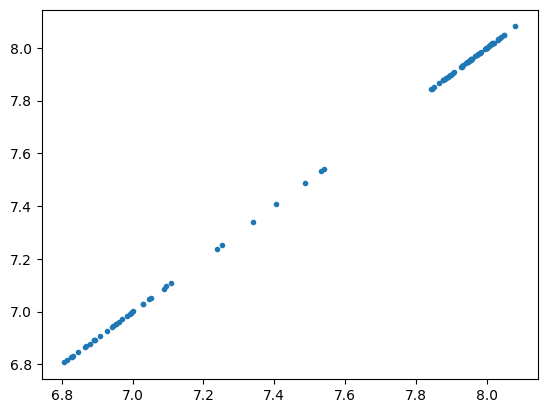

In [17]:
df1 = pd.read_csv("fit1.csv", index_col=0)
merged_df = titan.dataframes[1][["K", "sK"]].merge(
    df1, left_index=True, right_index=True
)
plt.plot(merged_df.K_y, merged_df.K_x, ".")

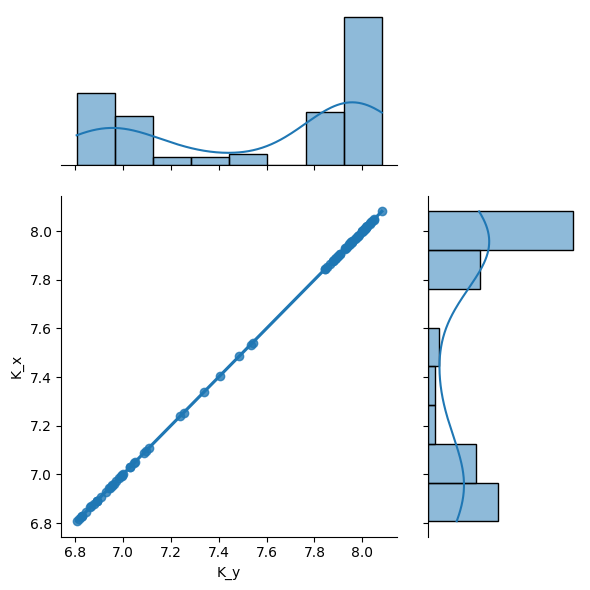

In [18]:
sb.jointplot(merged_df, x="K_y", y="K_x", kind="reg", ratio=2)

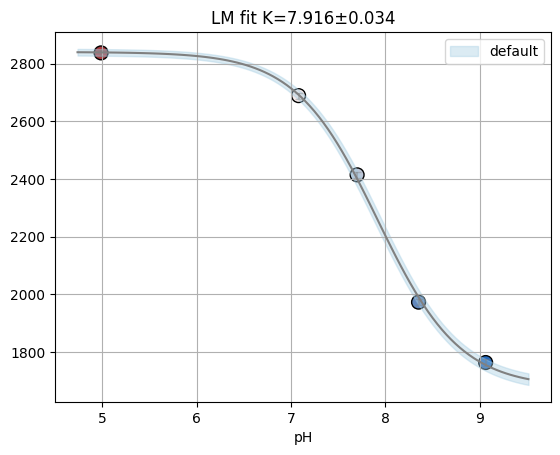

In [19]:
titan.fitresults[1]["A06"].figure
titan.fitresults[2]["A06"].figure
titan.fitresults[0]["A06"].figure

In [20]:
titan.data[1]["A01"]

[4646.25,
 3782.415,
 2058.94,
 827.86,
 471.15000000000003,
 316.52500000000003,
 253.68000000000004]

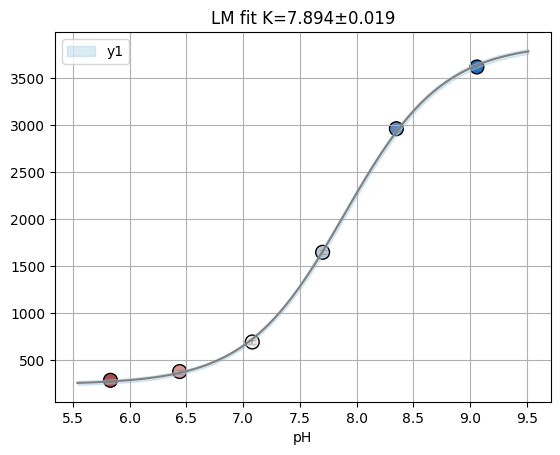

In [21]:
titan.fit_args = {"fin": -1}
titan.fitresults[2]["H02"].figure

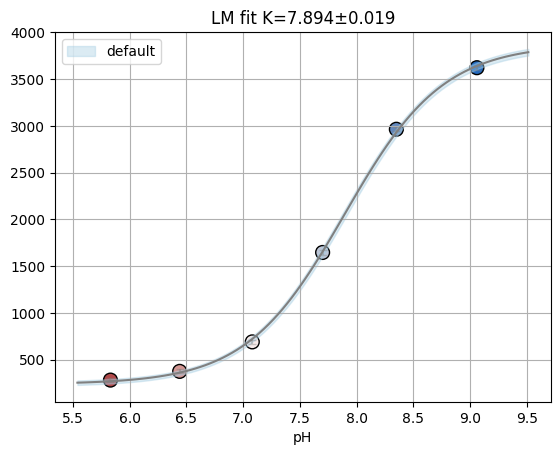

In [22]:
titan.fitresults[1]["H02"].figure

In [23]:
titan.fitresults[0]["H02"].figure

In [24]:
titan.fitresults[1].keys() - titan.fitresults[0].keys()

set()

In [25]:
titan.fitresults[0]["H02"]

FitResult(figure=None, result=None, mini=None)

In [26]:
# titan.export_png(2, "oouu")

In [27]:
well = "H02"
y0 = np.array(titan.data[0][well])
y1 = np.array(titan.labelblocksgroups[1].data_buffersubtracted[well])
y1 = np.array(titan.data[1][well])
x = np.array(titan.conc)
ds = fitting.Dataset(x, {"y0": y0, "y1": y1}, is_ph=True)
rfit = fitting.fit_binding_glob(ds)

rfit

/tmp/ipykernel_2574897/2369464149.py:7: UserWarning: Marking dataset y0 for removal due to insufficient data points.
  rfit = fitting.fit_binding_glob(ds)


FitResult(figure=<Figure size 640x480 with 1 Axes>, result=<lmfit.minimizer.MinimizerResult object at 0x7f001a8d7b80>, mini=<lmfit.minimizer.Minimizer object at 0x7f001a8d5840>)

In [28]:
titan.dataframes[1]

,S0_default,sS0_default,S1_default,sS1_default,K,sK,ctrl
well,,,,,,,
F09,349.363412,2.105205,22.271959,1.067598,7.867026,0.011981,NaN
G11,134.173634,1.537092,5.557582,0.665111,8.016779,0.020705,NaN
G02,471.004801,6.783922,20.463472,3.376779,7.885419,0.027793,NaN
E10,191.086888,1.356434,14.106486,0.597835,8.000184,0.013390,NaN
D03,1239.124270,7.898704,70.876728,3.882300,7.897767,0.012409,NaN
...,...,...,...,...,...,...,...
A04,285.700208,8.556501,44.312306,10.260984,6.846171,0.100990,NaN
F12,244.611841,2.714461,33.386519,1.854699,7.541851,0.027556,NTT
B06,631.051961,5.391083,88.362659,6.344871,6.869284,0.028035,NaN


### Fitting

In [29]:
titan.datafit_params = {"bg": 1, "nrm": 0, "dil": 0}
titan.datafit[1]["E06"]

[9215.25, 7038.25, 3318.75, 1361.0, 736.25, 558.75, 284.5]

In [30]:
set(titan.__dict__.keys()) - set(tit.__dict__.keys())

{'_datafit',
 '_datafit_params',
 '_dataframes',
 '_fit_args',
 '_fitresults',
 'fz',
 'keys_unk'}

In [31]:
remcee = rfit.mini.emcee(burn=50, steps=500, workers=8, thin=10)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 142.39it/s]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 10;
tau: [43.09137643 25.87374335 40.30187933]


[7.86, 7.91]


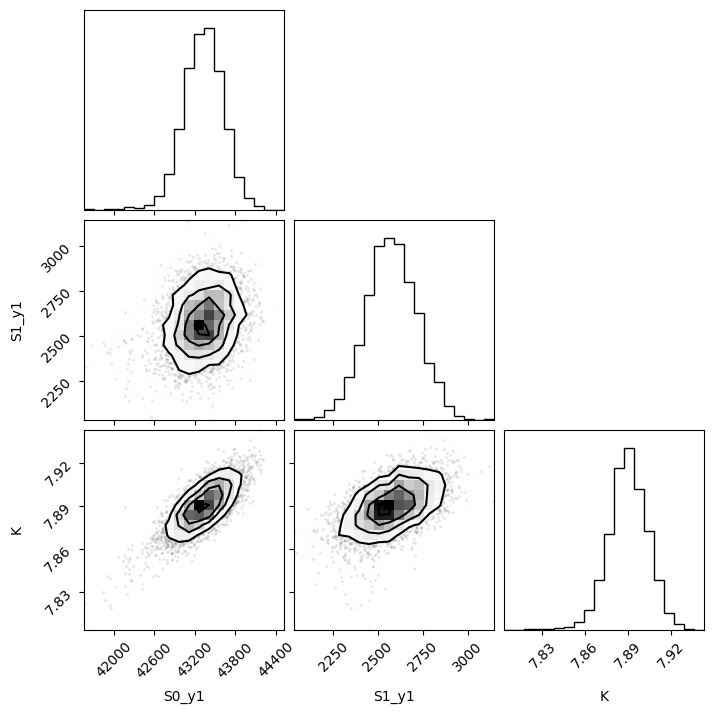

In [32]:
f, hdi = plotting.plot_emcee(remcee)
print(hdi)

Value at which the probability of being higher is 99%: 7.86396727541703


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

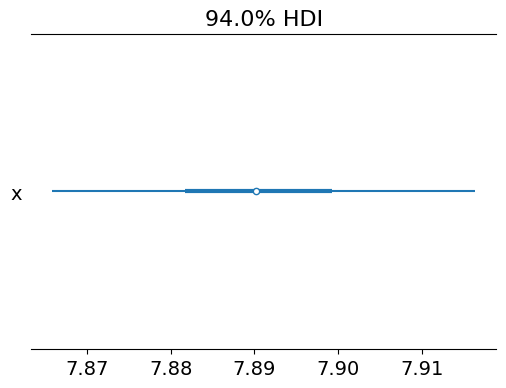

In [33]:
samples = remcee.flatchain[["K"]]
# Convert the dictionary of flatchains to an ArviZ InferenceData object
samples_dict = {key: np.array(val) for key, val in samples.items()}
idata = az.from_dict(posterior=samples_dict)
k_samples = idata.posterior["K"].values
percentile_value = np.percentile(k_samples, 3)
print(f"Value at which the probability of being higher is 99%: {percentile_value}")

az.plot_forest(k_samples)

## Cl titration analysis

In [34]:
cl_an = prtecan.TitrationAnalysis.fromlistfile("list.cl")
cl_an.load_scheme("scheme.txt")
cl_an.scheme

PlateScheme(file='scheme.txt', _buffer=['D01', 'E01', 'D12', 'E12'], _ctrl=['F01', 'C01', 'B12', 'H01', 'G12', 'A12', 'C12', 'F12', 'A01', 'H12', 'G01', 'B01'], _names={'G03': {'B12', 'A01', 'H12'}, 'NTT': {'F01', 'C12', 'F12'}, 'S202N': {'H01', 'G12', 'C01'}, 'V224Q': {'A12', 'G01', 'B01'}})

In [35]:
cl_an.load_additions("additions.cl")
print(cl_an.conc)
cl_an.conc = prtecan.calculate_conc(cl_an.additions, 1000)
cl_an.conc

[0, 0, 0, 0, 0, 0, 0, 0, 0]


array([  0.        ,  17.54385965,  34.48275862,  50.84745763,
        66.66666667,  81.96721311,  96.77419355, 138.46153846,
       164.17910448])

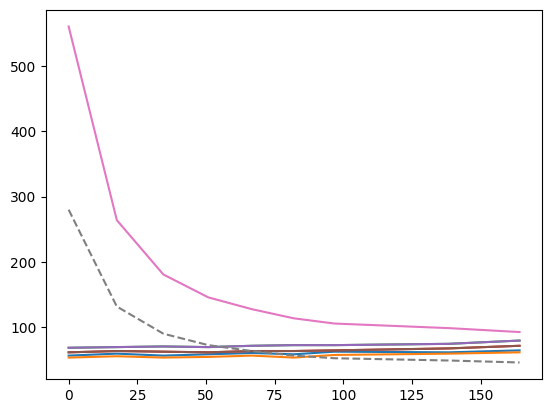

In [36]:
lbg = cl_an.labelblocksgroups[1]
x = cl_an.conc
plt.plot(x, lbg.data["D01"])
plt.plot(x, lbg.data["E01"])
plt.plot(x, lbg.data["D12"])
plt.plot(x, lbg.data["E12"])
plt.plot(x, cl_an.labelblocksgroups[1].data["D12"])
plt.plot(x, cl_an.labelblocksgroups[1].data["E12"])
plt.plot(x, lbg.data["A11"])
plt.plot(x, np.array(cl_an.labelblocksgroups[1].data["A11"]) / 2, "--")

In [37]:
lbg.labelblocks[1].buffer

62.5

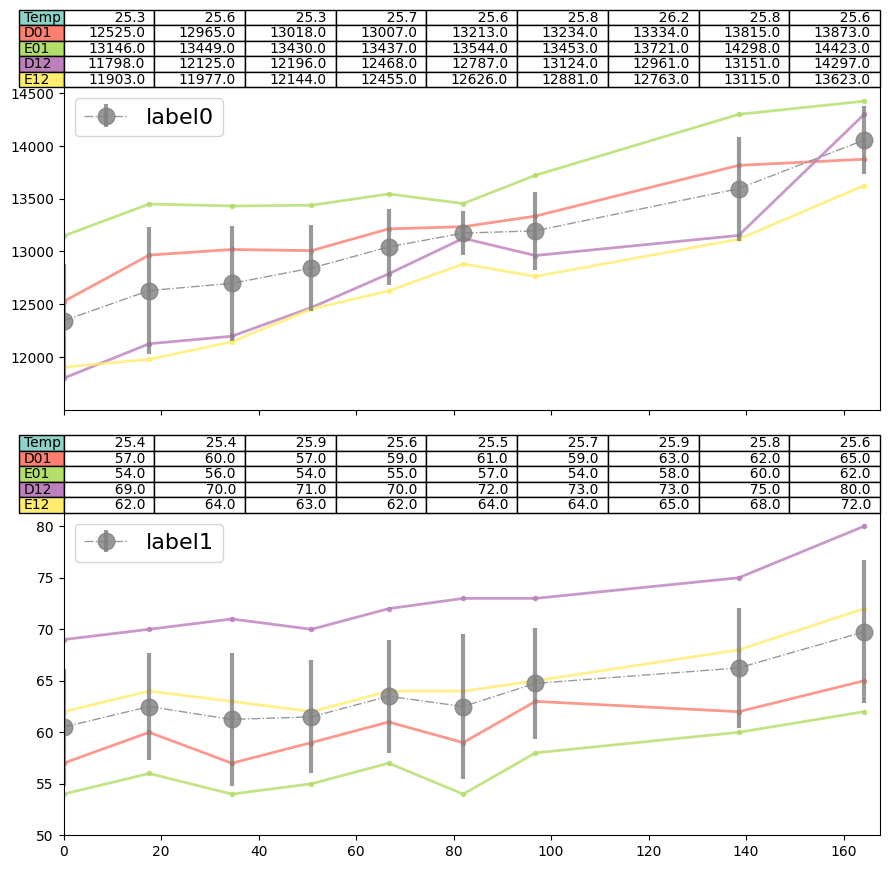

In [38]:
f = cl_an.plot_buffer()

In [39]:
titan.datafit_params = {}  # Use raw data
titan.fitresults[1]["H06"].result.params

name,value,standard error,relative error,initial value,min,max,vary
S0_default,9807.48237,12.5051545,(0.13%),8993.0,0.00000000,inf,True
S1_default,583.667692,6.27033228,(1.07%),635.0,-inf,inf,True
K,8.04449947,0.00240389,(0.03%),7.7,3.00000000,11.0000000,True


This what is done for each label.

In [40]:
well = "H06"
lbg = titan.labelblocksgroups[1]
x = titan.conc
y = lbg.data[well]
ds = fitting.Dataset(np.array(x), np.array(y), True)
fitting.fit_binding_glob(ds).result.params

name,value,standard error,relative error,initial value,min,max,vary
S0_default,9787.25916,76.0449214,(0.78%),8993.0,0.00000000,inf,True
S1_default,540.624381,32.2119976,(5.96%),455.0,-inf,inf,True
K,8.03575022,0.01411130,(0.18%),7.7,3.00000000,11.0000000,True


True 12.672459437038768 1.7500721513136166


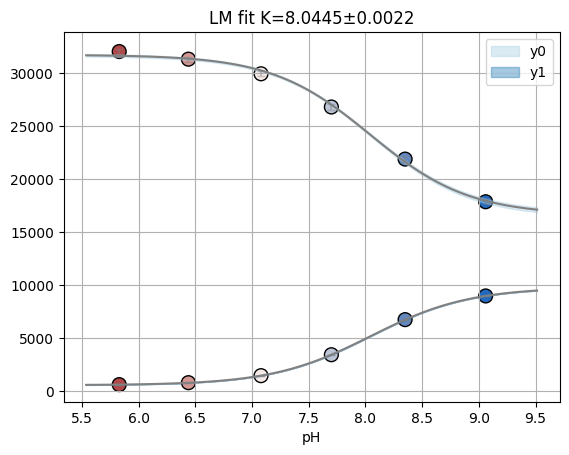

In [41]:
fres = titan.fitresults[2][well]
print(fres.is_valid(), fres.result.bic, fres.result.redchi)
fres.figure

In [42]:
# titan.plot_all_wells("cl.pdf")

In [43]:
titan.dataframes = []
titan.dataframes[0].loc["H02"]

S0_default     NaN
sS0_default    NaN
S1_default     NaN
sS1_default    NaN
K              NaN
sK             NaN
ctrl           NaN
Name: H02, dtype: object

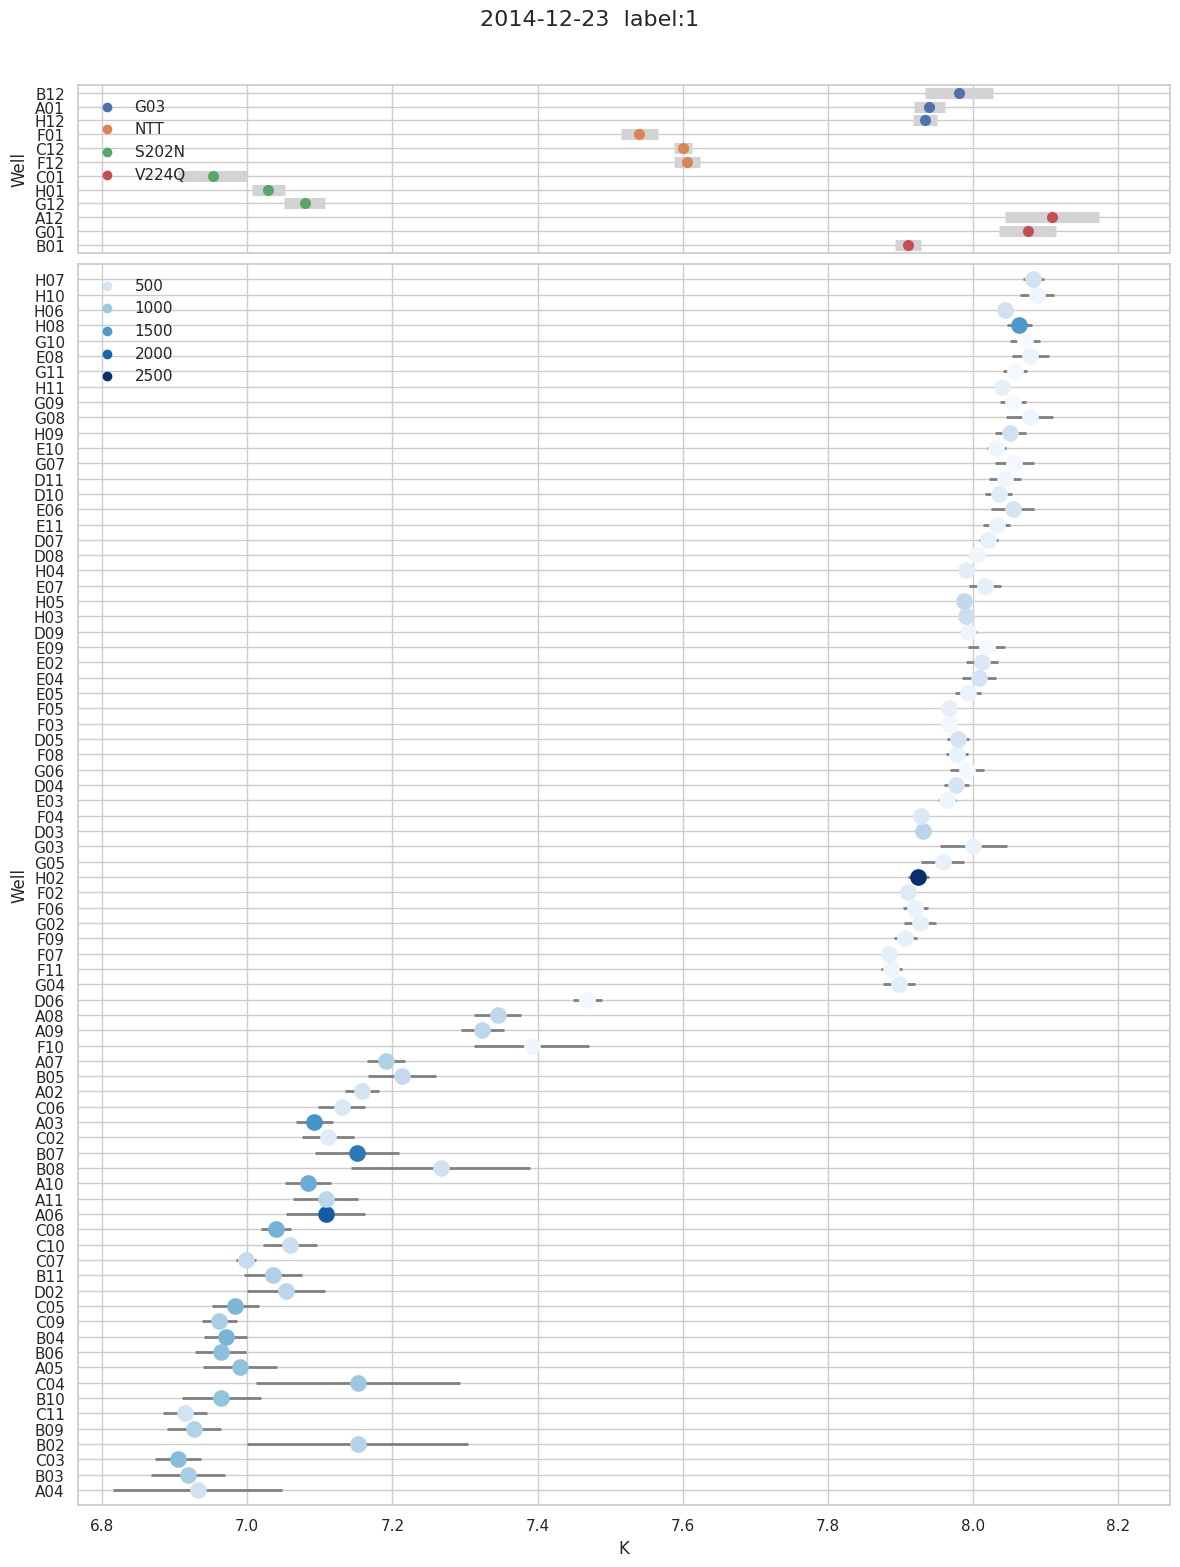

In [44]:
f = titan.plot_k(1, title="2014-12-23")

In [45]:
titan.print_fitting(2)

          K s      K   S0_y0 s  S0_y0   S1_y0 s  S1_y0   S0_y1 s  S0_y1   S1_y1 s  S1_y1
 G03
B12    7.99   0.043 1.43e+04 2.4e+02 1.89e+04 1.6e+02 2.82e+03      62     212      34
A01    7.94   0.021 1.46e+04 4.3e+02 2.27e+04 2.9e+02 5.06e+03      55     311      31
H12    7.93   0.018 1.42e+04 4.3e+02 2.28e+04   3e+02 5.71e+03      50     381      29
 NTT
F01    7.55   0.023 2.44e+04 4.3e+02 4.82e+04 3.8e+02 7.96e+03      73 1.11e+03      63
C12     7.6   0.014 1.51e+04 2.9e+02 2.23e+04 2.6e+02 2.54e+03      14     387      11
F12    7.61   0.017 1.58e+04   3e+02 2.37e+04 2.6e+02 2.8e+03      19     433      15
 S202N
C01    6.97    0.05 3.17e+04 7.2e+02 4.53e+04 9.8e+02 6.93e+03      96 1.06e+03 1.5e+02
H01    7.04   0.025 2.52e+04 2.6e+02 3.72e+04 3.4e+02 5.15e+03      38     830      55
G12     7.1    0.04 1.69e+04 2.3e+02 2.32e+04 2.9e+02 2.36e+03      27     414      38
 V224Q
A12    8.27   0.071 1.77e+04 5.9e+02 2.91e+04 2.4e+02 1.18e+04 6.2e+02     620 2.7e+02
G01    8.08   0.

## selection

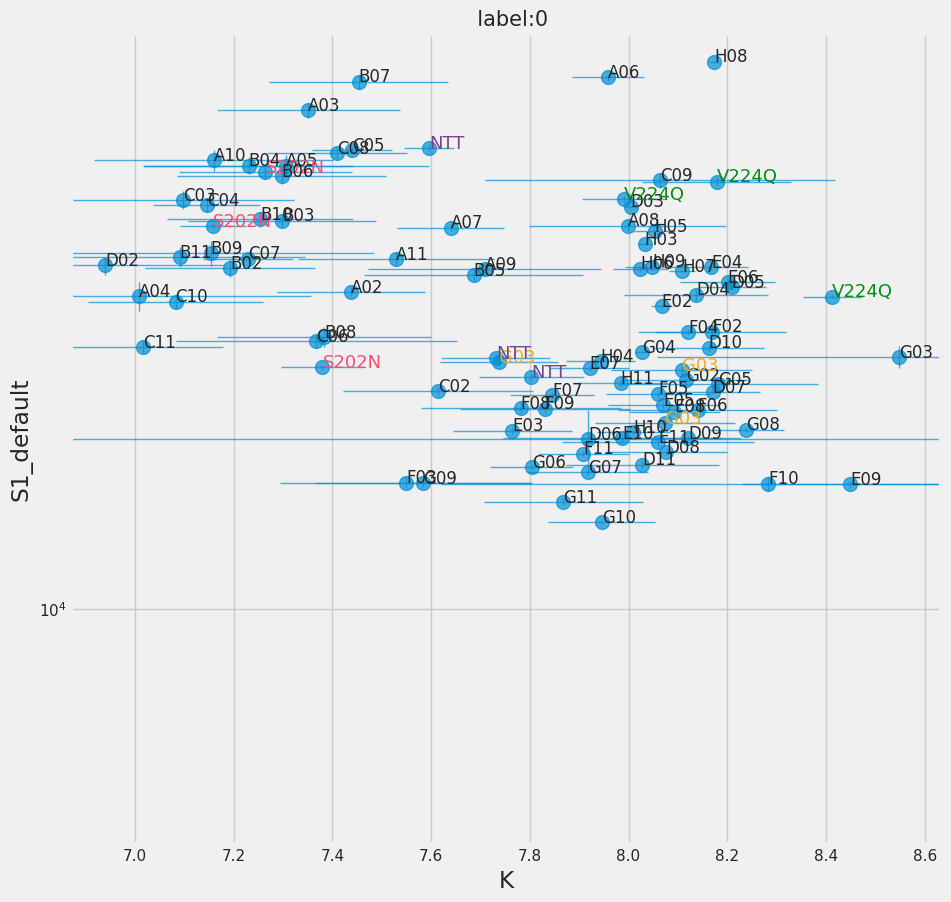

In [46]:
f = titan.plot_ebar(0, y="S1_default", yerr="sS1_default")

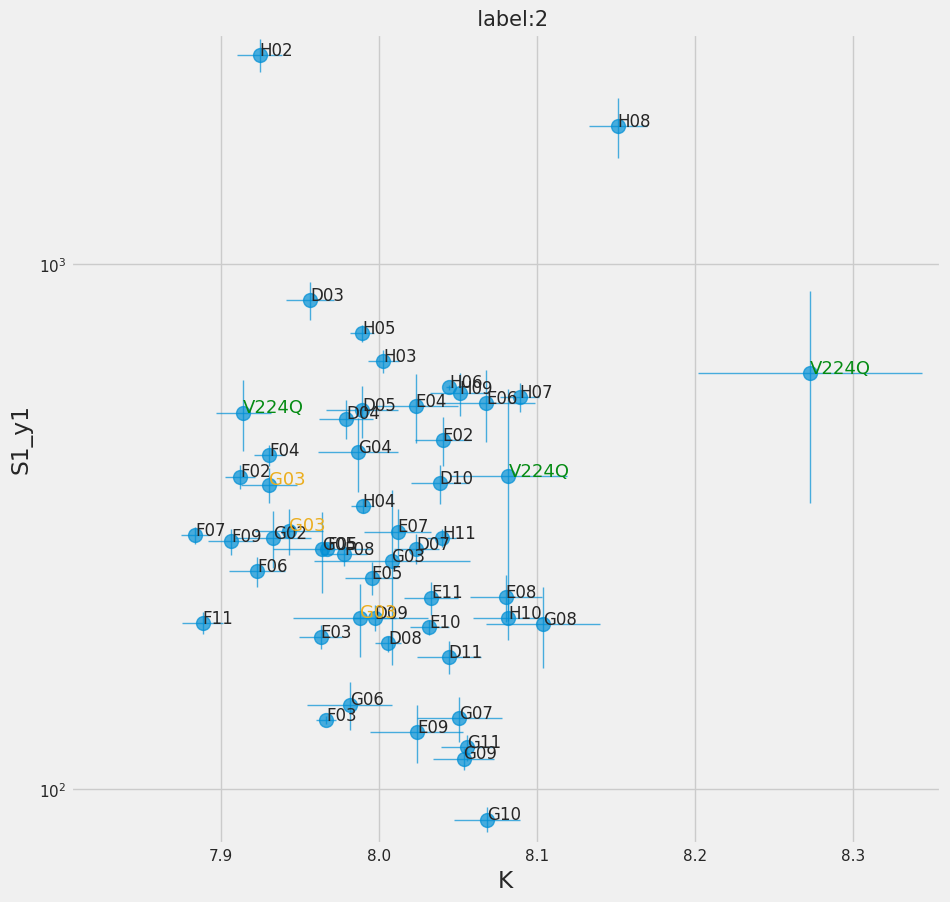

In [47]:
f = titan.plot_ebar(2, y="S1_y1", yerr="sS1_y1", xmin=7.7, ymin=25)

In [48]:
titan.dataframes[0]

,S0_default,sS0_default,S1_default,sS1_default,K,sK,ctrl
well,,,,,,,
F09,13473.516092,542.020942,19740.199924,348.896254,7.830370,0.171742,NaN
G11,11052.140342,275.509287,14385.097987,170.097661,7.867814,0.161051,NaN
G02,14393.666385,555.404097,21748.861854,254.236272,8.116766,0.128463,NaN
E10,13784.300492,535.691758,17852.355061,288.009763,7.987146,0.240994,NaN
D03,19951.215028,143.366071,39243.332681,75.477101,8.004585,0.013471,NaN
...,...,...,...,...,...,...,...
A04,20753.671137,929.104983,28938.686480,1431.581020,7.008064,0.348579,NaN
F12,15498.535407,422.457165,23468.565409,302.655465,7.731309,0.110586,NTT
B06,30199.749953,1083.386724,43568.575757,1215.378163,7.297294,0.211029,NaN


/home/dan/workspace/ClopHfit/.hatch/clophfit/lib/python3.10/site-packages/seaborn/axisgrid.py:1609: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=x, y=y, **kwargs)
/home/dan/workspace/ClopHfit/.hatch/clophfit/lib/python3.10/site-packages/seaborn/axisgrid.py:1609: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=x, y=y, **kwargs)
/home/dan/workspace/ClopHfit/.hatch/clophfit/lib/python3.10/site-packages/seaborn/axisgrid.py:1609: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=x, y=y, **kwargs)
/home/dan/workspace/ClopHfit/.hatch/clophfit/lib/python3.10/site-packages/seaborn/axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/home/dan/workspace/ClopHfit/.hatch/clophfit/lib/python3.10/site-packages/seaborn/axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  

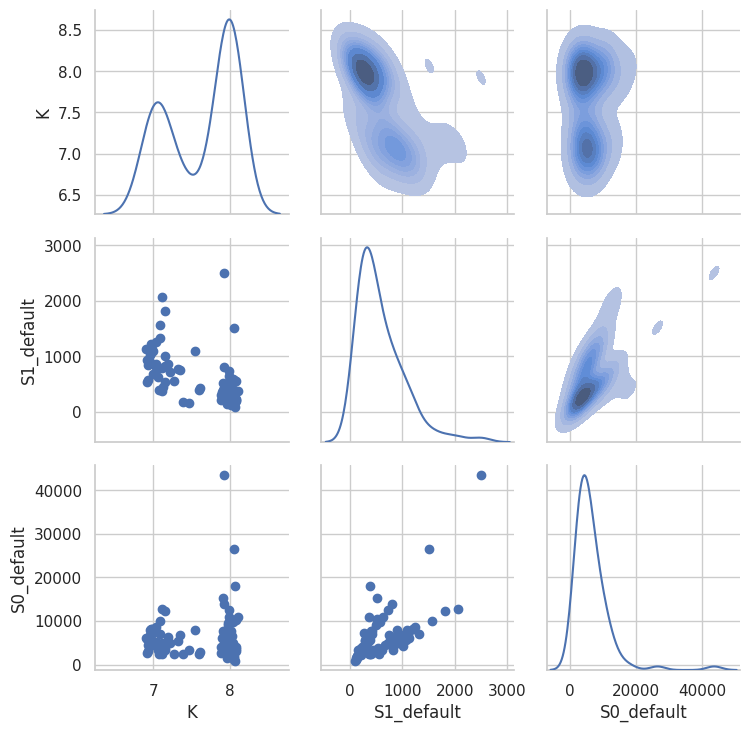

In [49]:
sb.set_style("whitegrid")
g = sb.PairGrid(
    titan.dataframes[1],
    x_vars=["K", "S1_default", "S0_default"],
    y_vars=["K", "S1_default", "S0_default"],
    # hue='SB',
    palette="Blues",
    diag_sharey=False,
)
g.map_lower(plt.scatter)
g.map_upper(sb.kdeplot, fill=True)
g.map_diag(sb.kdeplot)

Fit first (0) and second (1) dataset and global (2).

In [50]:
titan.dataframes[2]

,S0_y0,sS0_y0,S1_y0,sS1_y0,S0_y1,sS0_y1,S1_y1,sS1_y1,K,sK,ctrl
well,,,,,,,,,,,
F09,13300.715295,374.797031,19654.200626,265.496445,3983.625379,28.593169,297.046088,16.915909,7.906185,0.014786,NaN
G11,10807.336112,215.517240,14276.234261,136.947555,1565.645380,13.798398,120.259667,6.831339,8.055956,0.016781,NaN
G02,14964.570742,357.116497,21940.589480,246.404605,5365.911825,65.253157,301.174631,37.525191,7.932987,0.024092,NaN
E10,13709.380225,342.528267,17823.534080,222.258121,2203.528808,13.579589,203.430582,6.918537,8.031863,0.012116,NaN
D03,20327.043629,211.628954,39390.031846,131.028558,14111.617108,121.940941,855.768518,71.486253,7.956273,0.015260,NaN
...,...,...,...,...,...,...,...,...,...,...,...
A04,20860.555757,713.499107,29157.235003,1007.648088,3225.291243,87.609074,569.441329,145.411963,6.936312,0.102377,NaN
F12,15808.983445,298.078762,23665.743107,258.288967,2801.134385,18.556627,433.472785,15.123731,7.608528,0.017266,NTT
B06,31158.118210,818.215395,44948.388349,1100.679764,7077.892092,69.230540,1116.209948,111.413530,6.969160,0.036236,NaN


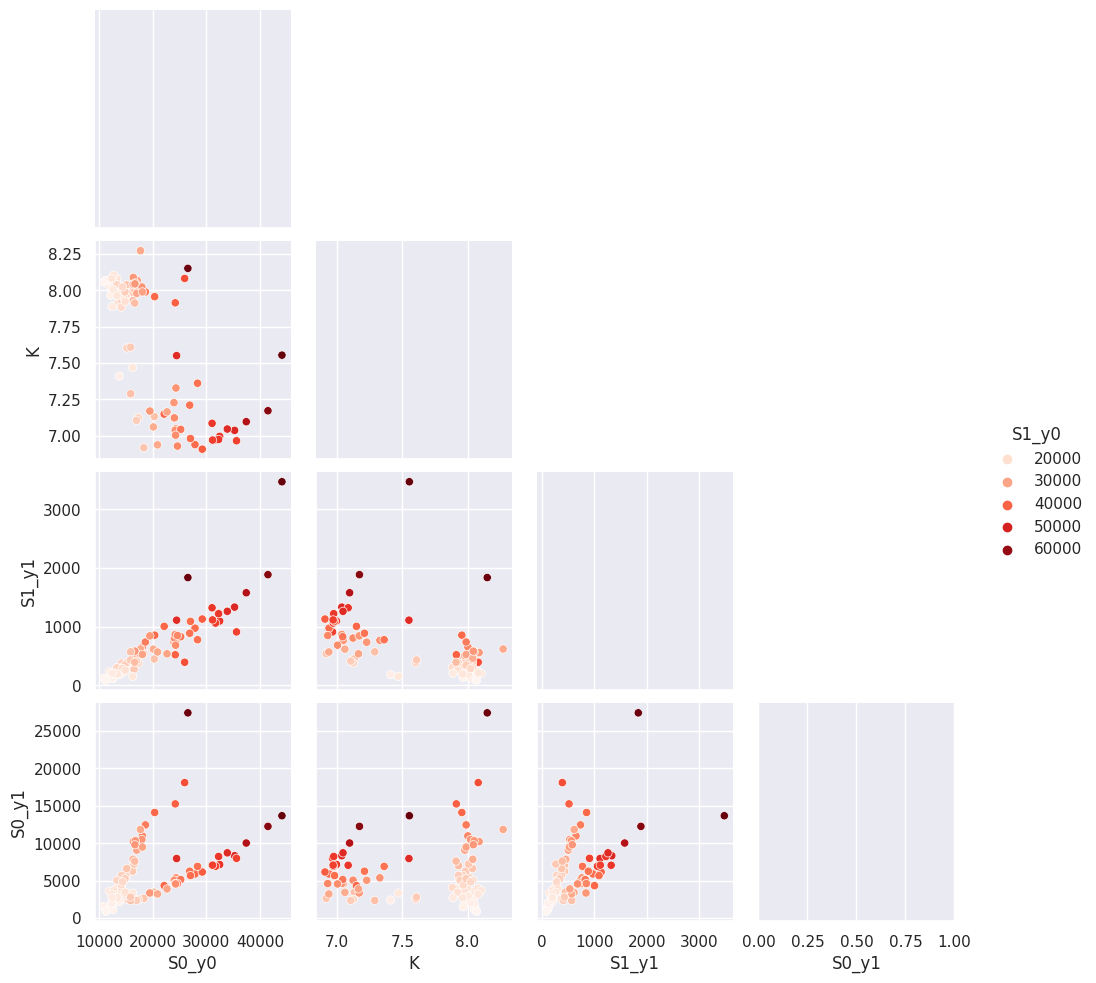

In [51]:
with sb.axes_style("darkgrid"):
    g = sb.pairplot(
        titan.dataframes[2][["S1_y0", "S0_y0", "K", "S1_y1", "S0_y1"]],
        hue="S1_y0",
        palette="Reds",
        corner=True,
        diag_kind="kde",
    )

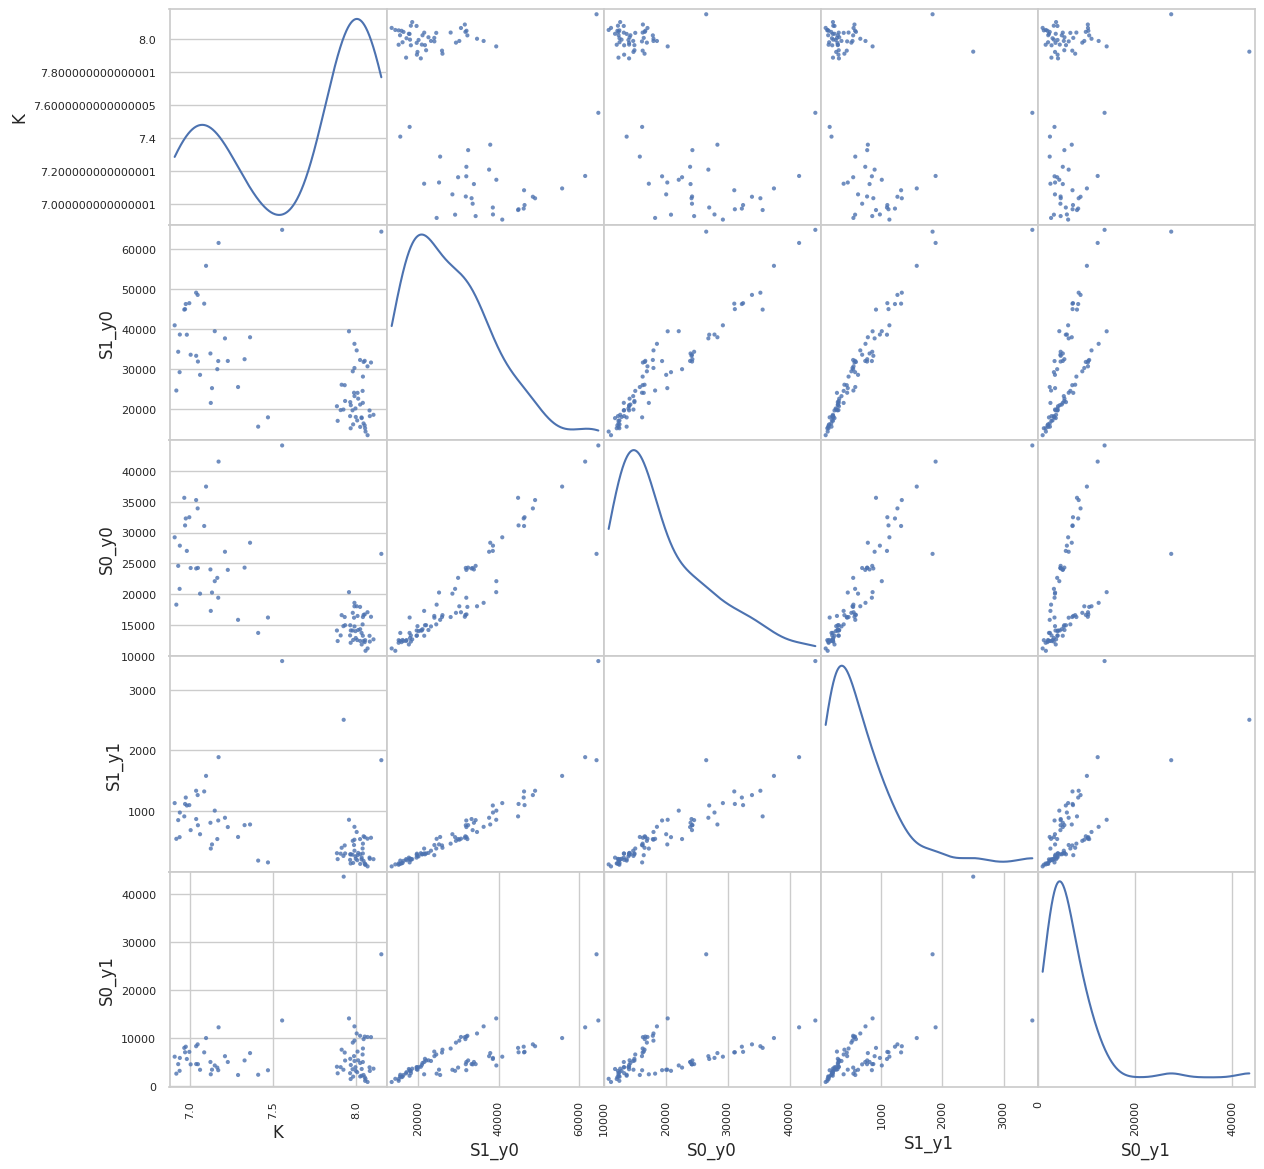

In [52]:
from pandas.plotting import scatter_matrix


def plot_matrix(tit, lb):
    df = tit.dataframes[lb].loc[tit.keys_unk]
    f = scatter_matrix(
        df[["K", "S1_y0", "S0_y0", "S1_y1", "S0_y1"]],
        figsize=(14, 14),
        diagonal="kde",
        alpha=0.8,
    )
    return f


f = plot_matrix(titan, 2)

### combining

In [53]:
res_unk = titan.dataframes[1].loc[titan.keys_unk].sort_index()
res_unk["well"] = res_unk.index

<Figure size 2400x1400 with 0 Axes>

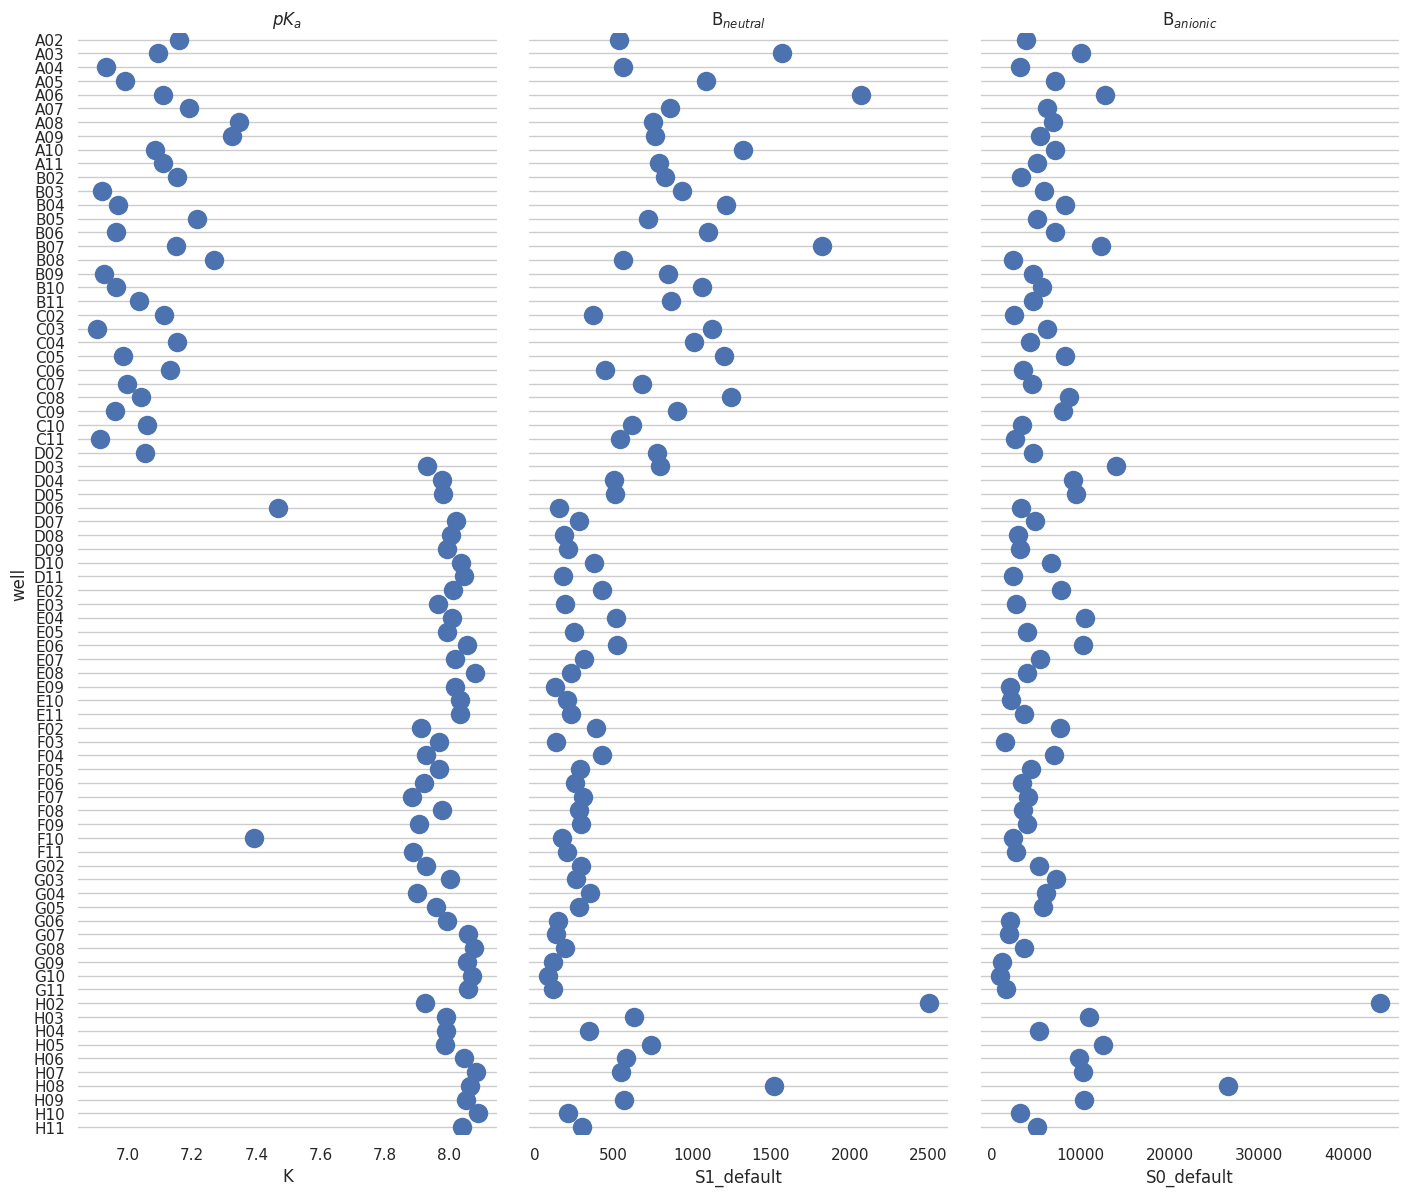

In [54]:
# g = sns.FacetGrid(data=res2, row='well',  margin_titles=True)
# g.map(plt.errorbar, 'K', range(1), xerr='sK', palette='Oranges_d') # x, y,
f = plt.figure(figsize=(24, 14))

# Make the PairGrid
g = sb.PairGrid(
    res_unk,
    x_vars=["K", "S1_default", "S0_default"],
    y_vars="well",
    height=12,
    aspect=0.4,
)


# Draw a dot plot using the stripplot function
g.map(sb.stripplot, size=14, orient="h", palette="Set2", edgecolor="gray")

# Use the same x axis limits on all columns and add better labels
# g.set(xlim=(0, 25), xlabel="Crashes", ylabel="")

# Use semantically meaningful titles for the columns
titles = ["$pK_a$", "B$_{neutral}$", "B$_{anionic}$"]


for ax, title in zip(g.axes.flat, titles):
    # Set a different title for each axes
    ax.set(title=title)

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sb.despine(left=True, bottom=True)